# Getting started


First the imports.


In [ ]:
import pickle
from pprint import pprint
from typing import Literal

import numpy as np
import pandas as pd

from pepme.core import (
    Metric,
    MetricResult,
    SequenceCache,
    barplot,
    combine_metric_dataframes,
    compute_metrics,
    random_subset,
    show_table,
)
from pepme.metrics.fid import FID
from pepme.metrics.gravy import Gravy
from pepme.metrics.novelty import Novelty
from pepme.utils import read_fasta_file, write_to_fasta_file

## Basics


Let's define the sequences to use and the metrics to compute. Some sequences will be loaded from fasta files, others are hard-coded.


First let's write a fasta file with random sequences to disk.


In [ ]:
RANDOM_SEQUENCES_PATH = "../data/random.fasta"

In [ ]:
random_sequences = ["KKKKK", "PLUQ", "RKSPL"]

write_to_fasta_file(random_sequences, RANDOM_SEQUENCES_PATH)

UniProt contains a lot of sequences. To speed-up the metric computations, we will only use a (random) subset of the UniProt sequences.


In [ ]:
sequences = {
    "Random": read_fasta_file(RANDOM_SEQUENCES_PATH),
    "UniProt": random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
    "HydrAMP": ["MMRK", "RKSPL", "RRLSK"],
    "hyformer": ["MKQW", "RKSPL"],
}


# @TODO: replace with PhysicoChemicalEmbedder when implemented
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


metrics = [
    Novelty(reference=["KKW", "RKSPL"]),
    Novelty(reference=sequences["Random"], reference_name="Random"),
    FID(reference=sequences["Random"], embedder=my_embedder),
    Gravy(),
]

df = compute_metrics(sequences, metrics)

100%|██████████| 16/16 [00:00<00:00, 2554.19it/s, data=hyformer, metric=Gravy]           


**Tip:** Unsure about which metrics to compute? If you don't define the metrics, pepme will úse its recommended metrics.


Let's look at the results.


In [ ]:
df

Novelty           Novelty (Random)                 FID            \
             value deviation            value deviation     value deviation   
Random    0.666667       NaN         0.000000       NaN  0.000000       NaN   
UniProt   1.000000       NaN         1.000000       NaN  3.294463       NaN   
HydrAMP   0.666667       NaN         0.666667       NaN  8.000000       NaN   
hyformer  0.500000       NaN         0.500000       NaN  8.044615       NaN   

             Gravy            
             value deviation  
Random   -0.380417  0.293968  
UniProt  -0.600000  0.162500  
HydrAMP  -0.321167  0.053004  
hyformer -0.340000  0.060000

... let's make it nicer to look at.


In [ ]:
show_table(df, decimals=2)

,Novelty↑,Novelty (Random)↑,FID↓,Gravy
Random,0.67,0.00,0.00,-0.38±0.29
UniProt,1.00,1.00,3.29,-0.60±0.16
HydrAMP,0.67,0.67,8.00,-0.32±0.05
hyformer,0.50,0.50,8.04,-0.34±0.06


We are particularly interested in the following metric.


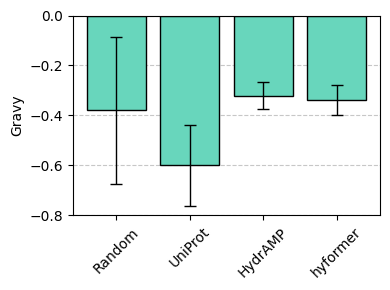

In [ ]:
barplot(df, "Gravy")

To write a metric dataframe to disk, encode the dataframe as a pickle object.


In [ ]:
PATH = "./metrics_dataframe.pkl"

df.to_pickle(PATH)
show_table(pd.read_pickle(PATH))

,Novelty↑,Novelty (Random)↑,FID↓,Gravy
Random,0.67,0.00,0.00,-0.38±0.29
UniProt,1.00,1.00,3.29,-0.60±0.16
HydrAMP,0.67,0.67,8.00,-0.32±0.05
hyformer,0.50,0.50,8.04,-0.34±0.06


That it all for the basic usage of pepme. Let's look at some more advanced features!


## Advanced


In the advanced section, we show how to

- Combine multiple metric dataframes into one.
- Improve performance through caching.
- Create your own metric.


### Combining metric dataframes

pepme's `combine_metric_dataframes` can combine metric dataframes with different sequences and/or metrics. This can be useful if you want to evaluate the sequences on an additional metric or add an additional set of sequences for evaluation - without needing to recompute the results.


Let's create three metric dataframes.


In [ ]:
df1 = compute_metrics(
    sequences={
        "s1": ["KKKKK", "PLUQ", "RKSPL"],
        "s2": random_subset(["KKWQ", "RKSPL", "RASD"], n_samples=2, seed=42),
        "s3": ["MMRK", "RKSPL", "RRLSK"],
        "s4": ["MKQW", "RKSPL"],
    },
    metrics=[
        Novelty(reference=["KKW", "RKSPL"]),
        Novelty(reference=["RASD", "KKKQ", "LPTUY"], reference_name="Random"),
    ],
    verbose=False,
)

df2 = compute_metrics(
    sequences={"s4": ["MKQW", "RKSPL"], "s5": ["MKQW"]},
    metrics=[Gravy()],
    verbose=False,
)

df3 = compute_metrics(
    sequences={"s6": ["MKQW", "RKSPL"]},
    metrics=[Gravy(), Novelty(reference=["KKW", "RKSPL"])],
    verbose=False,
)

Let's combine the dataframes.


In [ ]:
df = combine_metric_dataframes([df1, df2, df3])

In [ ]:
df

Novelty           Novelty (Random)           Gravy          
       value deviation            value deviation value deviation
s1  0.666667       NaN              1.0       NaN   NaN       NaN
s2  1.000000       NaN              0.5       NaN   NaN       NaN
s3  0.666667       NaN              1.0       NaN   NaN       NaN
s4  0.500000       NaN              1.0       NaN -0.34      0.06
s5       NaN       NaN              NaN       NaN -0.40      0.00
s6  0.500000       NaN              NaN       NaN -0.34      0.06

... let's make it nicer to look at.


In [ ]:
show_table(df, decimals=[3, 2, 1], color="#d66868")

,Novelty↑,Novelty (Random)↑,Gravy
s1,0.667,1.00,-
s2,1.000,0.50,-
s3,0.667,1.00,-
s4,0.500,1.00,-0.3±0.1
s5,-,-,-0.4±0.0
s6,0.500,-,-0.3±0.1


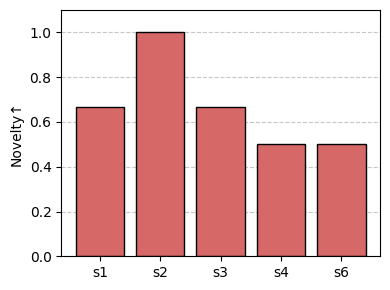

In [ ]:
barplot(df, "Novelty", color="#d66868", ylim=(0.0, 1.1), x_ticks_label_rotation=0.0)

Notice missing values (e.g., "Novelty" for "s5") are not shown in the barplot.


### Caching


Discriminators and embedders can be computational expensive to execute. To reduce the number of function evaluations for these models, we can cache the results of discriminators and embedders.

The cache works like this: If a (sequence, embedding)-pair is already stored in the cache then retrieve the embedding. Otherwise compute the embedding, store the pair in the cache and retrieve the embedding.

Let's create two toy models and the cache.


In [ ]:
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


def my_discriminator(sequences: list[str]) -> np.ndarray:
    return np.ones(len(sequences)) * 0.85


cache = SequenceCache(
    models={
        "embedder": my_embedder,
        "discriminator": my_discriminator,
    }
)

Optional: We can manually add model outputs to the cache. This is useful when e.g., (sequence, embedding)-pairs are already pre-computed and stored in a file.


In [ ]:
seqs = ["MKQW", "AA", "BB"]
reps = my_embedder(seqs)

pairs = {seq: rep for seq, rep in zip(seqs, reps)}

cache.add(model_name="embedder", pairs=pairs)

Let's compute the metrics. Since both `FID` objects use the same embedding model (`embedder`), the embedding is only computed once per sequence in `sequences` (instead of twice)!

Notice, we now use `cache.model()` instead of the embedder reference directly.


In [ ]:
df = compute_metrics(
    sequences={
        "hyformer": ["MKQW", "RKSPL", "RASD"],
        "HydrAMP": ["MKQW", "RKSPL"],
        "Random": ["AAAA", "PPPPP"],
    },
    metrics=[
        FID(
            reference=["AAAA", "PPPPP"],
            reference_name="Random",
            embedder=cache.model("embedder"),
        ),
        FID(
            reference=["KKRK", "QRR"],
            reference_name="UniProt",
            embedder=cache.model("embedder"),
        ),
    ],
)

show_table(df, color="#68afd6")

100%|██████████| 6/6 [00:00<00:00, 2320.29it/s, data=Random, metric=FID (UniProt)]  


,FID (Random)↓,FID (UniProt)↓
hyformer,0.82,4.11
HydrAMP,1.00,5.75
Random,0.00,7.75


Let's write the cached (sequence, embedding)-pairs for each model to a file and reinitialize the cache.


In [ ]:
PATH = "precomputed.pkl"

with open(PATH, "wb") as f:
    pickle.dump(cache.get(), f)

with open(PATH, "rb") as f:
    precomputed = pickle.load(f)

cache = SequenceCache(init_cache=precomputed)
pprint(cache.get())

{'discriminator': {},
 'embedder': {'AA': array([2, 0]),
              'AAAA': array([4, 0]),
              'BB': array([2, 0]),
              'KKRK': array([4, 3]),
              'MKQW': array([4, 1]),
              'PPPPP': array([5, 0]),
              'QRR': array([3, 0]),
              'RASD': array([4, 0]),
              'RKSPL': array([5, 1])}}


### Creating a new metric


You can also intergrate your own metrics into pepme through the `Metric` interface as shown below.


In [ ]:
class MyMetric(Metric):
    def __init__(self, amino_acid: str, minimize: bool = True):
        self.amino_acid = amino_acid
        self.minimize = minimize

    def __call__(self, sequences: list[str]) -> MetricResult:
        aa_count = sum([seq.count(self.amino_acid) for seq in sequences])
        aa_total = sum([len(sequence) for sequence in sequences])
        return MetricResult(aa_count / aa_total)

    @property
    def name(self) -> str:
        return f"{self.amino_acid}-frequency"

    @property
    def objective(self) -> Literal["minimize", "maximize", "ambiguous"]:
        return "minimize" if self.minimize else "maximize"

Let's use our new metric.


In [ ]:
df = compute_metrics(
    sequences={
        "hyformer": ["MKQW", "RKSPL", "RASD"],
        "HydrAMP": ["MKQW", "RKSPL"],
        "Random": ["AAAA", "PPPPP"],
    },
    metrics=[
        MyMetric(amino_acid="K", minimize=False),
        MyMetric(amino_acid="R", minimize=True),
    ],
)

show_table(df, color="#e07fe1")

100%|██████████| 6/6 [00:00<00:00, 3747.70it/s, data=Random, metric=R-frequency]  


,K-frequency↑,R-frequency↓
hyformer,0.15,0.15
HydrAMP,0.22,0.11
Random,0.00,0.00


This is all there is to pepme! 🎉
